# Прогнозирование стоимости подержанного автомобиля в Москве

### Постановка задачи

Идеей проекта является построение модели, которую можно использовать для оценки стоимости подержанного автомобиля. 

Для маркетплейсов по продаже автомобилей такая модель могла бы лечь в основу рекомендательной системы при размещении объявлений, а рядовые автомобилисты могли бы использовать эту модель для оценки остаточной стоимости автомобиля и выбора наиболее благоприятного момента для продажи.

### Оглавление

- Импорт библиотек
- Загрузка набора данных и первый взгляд
- Описание набора данных
- Подготовка данных для визуализации
- Визуальный анализ данных




## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
sns.set(style="whitegrid", font_scale=1.2)
%matplotlib inline

In [2]:
pd.set_option('precision', 2)
plt.rcParams['figure.figsize'] = (15, 8)

## Загрузка набора данных и первый взгляд

In [3]:
df = pd.read_csv('../Auto.ru Car Price Prediction/auto_ru_df.csv', index_col=False,
                 names = ['car_description','year', 'engine', 'power', 'gas', 'transmission', \
                          'body', 'drive', 'color','mileage', 'price'])

In [4]:
df.head()

,car_description,year,engine,power,gas,transmission,body,drive,color,mileage,price
0,LADA () 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,100 000 км,21 000 ₽
1,LADA () 2104 5-speed,1990,1.5,72,Бензин,механика,универсал 5 дв.,задний,красный,91 000 км,99 000 ₽
2,LADA () 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,32 000 км,80 000 ₽
3,LADA () 2107,1990,1.3,64,Бензин,механика,седан,задний,красный,250 000 км,45 000 ₽
4,LADA () 2106,1990,1.3,64,Бензин,механика,седан,задний,голубой,68 000 км,28 000 ₽


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114106 entries, 0 to 114105
Data columns (total 11 columns):
car_description    114106 non-null object
year               114106 non-null int64
engine             114106 non-null float64
power              114106 non-null int64
gas                114106 non-null object
transmission       114106 non-null object
body               114105 non-null object
drive              114105 non-null object
color              114105 non-null object
mileage            114105 non-null object
price              114105 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 9.6+ MB


Удаляем запись с пропущенными значениями

In [6]:
df.dropna(how = 'any', inplace = True)

Удаляем лишнее из колонок

In [7]:
df['car_description'] = df['car_description'].astype('str').str.replace(r'\(\)','')
df['gas'] = df['gas'].str.replace('\s+','')
df['price'] = df['price'].str.replace('\s+','').str.replace('₽', '')
df['mileage'] = df['mileage'].str.replace('\s+', '').str.replace('км', '')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114105 entries, 0 to 114104
Data columns (total 11 columns):
car_description    114105 non-null object
year               114105 non-null int64
engine             114105 non-null float64
power              114105 non-null int64
gas                114105 non-null object
transmission       114105 non-null object
body               114105 non-null object
drive              114105 non-null object
color              114105 non-null object
mileage            114105 non-null object
price              114105 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 10.4+ MB


Приводим пробег и цену к числовому типу

In [8]:
df['mileage'] = df['mileage'].astype('int32')
df['price'] = df['price'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114105 entries, 0 to 114104
Data columns (total 11 columns):
car_description    114105 non-null object
year               114105 non-null int64
engine             114105 non-null float64
power              114105 non-null int64
gas                114105 non-null object
transmission       114105 non-null object
body               114105 non-null object
drive              114105 non-null object
color              114105 non-null object
mileage            114105 non-null int32
price              114105 non-null int32
dtypes: float64(1), int32(2), int64(2), object(6)
memory usage: 9.6+ MB


In [9]:
df.describe()

,year,engine,power,mileage,price
count,114105.00,114105.00,114105.00,114105.00,1.14e+05
mean,2009.22,2.22,160.17,143259.07,7.52e+05
std,5.68,2.48,79.57,87023.87,9.38e+05
min,1990.00,0.70,29.00,1.00,1.50e+04
25%,2006.00,1.60,106.00,84000.00,2.80e+05
50%,2010.00,2.00,141.00,130000.00,5.15e+05
75%,2013.00,2.50,184.00,188000.00,8.90e+05
max,2018.00,170.00,717.00,1000000.00,8.89e+07


Максимальный объем двигателя в 170 литров выглядит подозрительно, вероятно, люди опечатывались или путали с другими единицами измерения.Подрежем на разумном значении.

In [10]:
def cutter(x):
    if x < 10:
        return x
    else:
        return x / 100
    
    
df['engine'] = df['engine'].apply(cutter)
df.describe()

,year,engine,power,mileage,price
count,114105.00,114105.00,114105.00,114105.00,1.14e+05
mean,2009.22,2.18,160.17,143259.07,7.52e+05
std,5.68,0.88,79.57,87023.87,9.38e+05
min,1990.00,0.67,29.00,1.00,1.50e+04
25%,2006.00,1.60,106.00,84000.00,2.80e+05
50%,2010.00,2.00,141.00,130000.00,5.15e+05
75%,2013.00,2.50,184.00,188000.00,8.90e+05
max,2018.00,8.40,717.00,1000000.00,8.89e+07


In [11]:
df.head()

,car_description,year,engine,power,gas,transmission,body,drive,color,mileage,price
0,LADA 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,100000,21000
1,LADA 2104 5-speed,1990,1.5,72,Бензин,механика,универсал 5 дв.,задний,красный,91000,99000
2,LADA 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,32000,80000
3,LADA 2107,1990,1.3,64,Бензин,механика,седан,задний,красный,250000,45000
4,LADA 2106,1990,1.3,64,Бензин,механика,седан,задний,голубой,68000,28000


In [12]:
df.duplicated().value_counts()

False    113154
True        951
dtype: int64

Удаляем одинаковые записи

In [13]:
df.drop_duplicates(inplace = True)
df.duplicated().value_counts()

False    113154
dtype: int64

In [14]:
df.shape

(113154, 11)

## Описание набора данных

Датасет был получен с помощью скрипта web_scraper.py, который находится в этой же директории. Получение html-страницы сделано с помощью библиотеки Selenium, парсинг осуществлен через библиотеку BeautifulSoup. Парсились объявления с сайта auto.ru в категории подержанные автомобили, территориально расположенные в Москве и 200-километровой окружности.

Набор данных содержит в себе 113154 запись и 11 признаков: 4 числовых, 6 категориальных и целевой.

* car_description - марка, модель и поколение автомобиля
* year - год выпуска
* engine - объем двигателя в литрах
* power - мощность двигателя в лошадиных силах
* gas - типа используемого топлива
* transmission - тип коробки передач
* body -  форма кузова
* drive - привод
* color - цвет кузова
* mileage - пробег
* price - цена



## Подготовка данных для визуализации

Удаляем вторую часть названия производителя "Land Rover", чтобы правильно извлечь названия модели

In [15]:
df['car_description'] = df['car_description'].astype('str').str.replace('Rover','')

Вытаскиваем полезную информацию из столбца "car_description" и удаляем его

In [16]:
manufacturer = df['car_description'].apply(lambda x : x.split()[0])
model = df['car_description'].apply(lambda x : x.split()[1])
restyling = df['car_description'].str.contains('Рестайлинг').astype('int32')
df.insert(0, 'manufacturer', manufacturer)
df.insert(1, 'model', model)
df.insert(2, 'restyling', restyling)
df.drop('car_description', axis = 1, inplace = True);

In [17]:
df['manufacturer'] = df['manufacturer'].str.replace('Land','Land Rover')

In [18]:
df.head()

,manufacturer,model,restyling,year,engine,power,gas,transmission,body,drive,color,mileage,price
0,LADA,2106,0,1990,1.3,64,Бензин,механика,седан,задний,бежевый,100000,21000
1,LADA,2104,0,1990,1.5,72,Бензин,механика,универсал 5 дв.,задний,красный,91000,99000
2,LADA,2106,0,1990,1.3,64,Бензин,механика,седан,задний,бежевый,32000,80000
3,LADA,2107,0,1990,1.3,64,Бензин,механика,седан,задний,красный,250000,45000
4,LADA,2106,0,1990,1.3,64,Бензин,механика,седан,задний,голубой,68000,28000


##  Визуальный анализ данных

### Распределение целевого признака

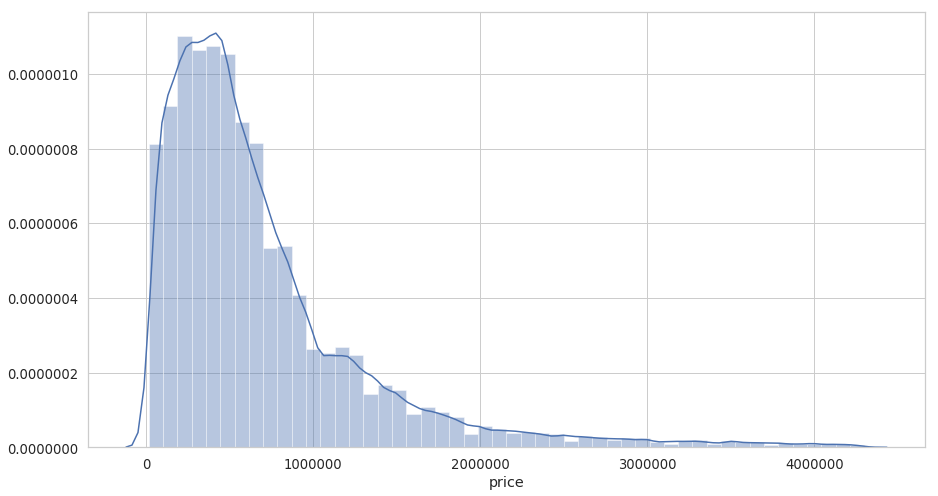

In [19]:
sns.distplot(df[(df['price']<df['price'].quantile(.99))]['price']);

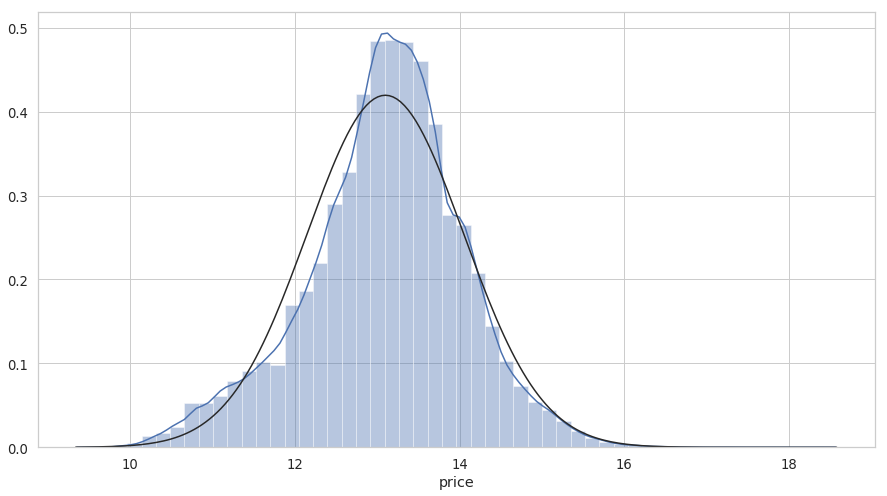

In [20]:
sns.distplot(df['price'].map(np.log), fit=st.norm);

### Распределения наблюдений по категориям

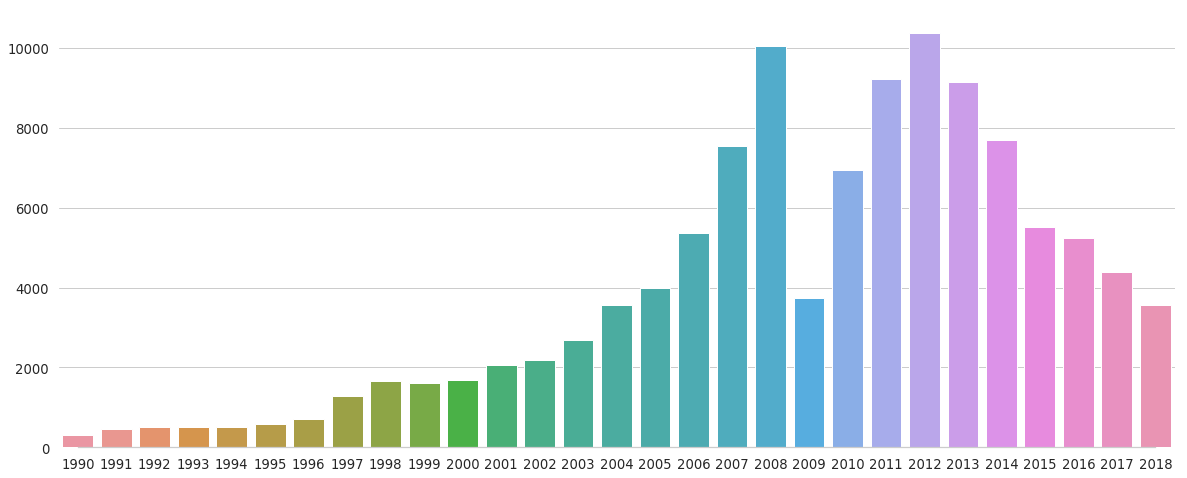

In [21]:
f, ax = plt.subplots(figsize=(20,8))
sns.countplot(x='year', data=df);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

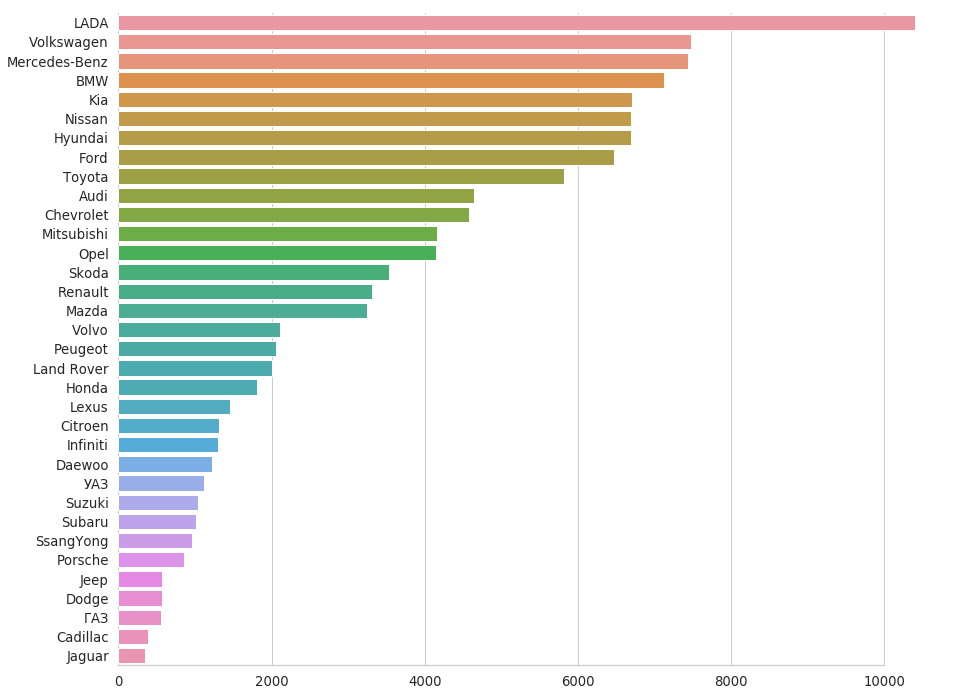

In [22]:
f, ax = plt.subplots(figsize=(15,12))
sns.countplot(y='manufacturer', data=df, order=df['manufacturer'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

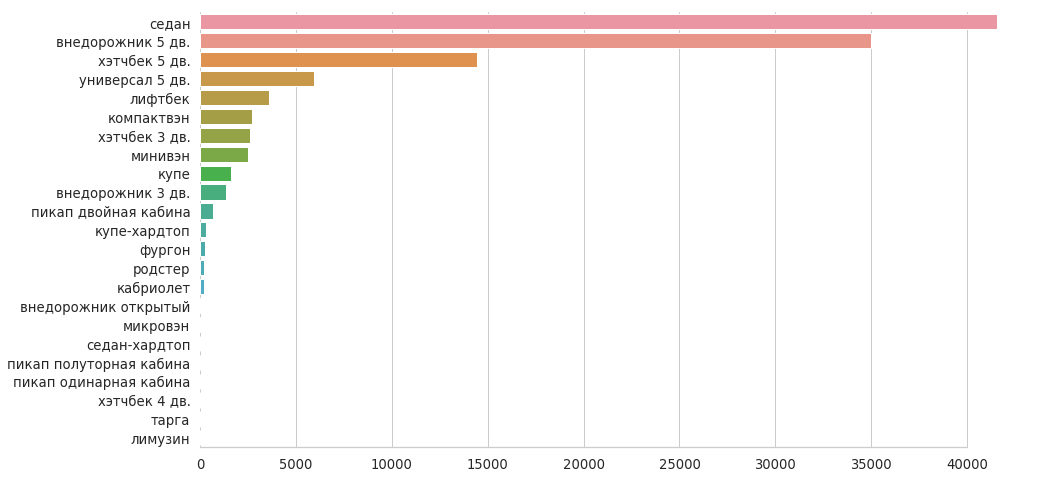

In [23]:
f, ax = plt.subplots(figsize=(15,8))
sns.countplot(y=df['body'], data=df, order=df['body'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

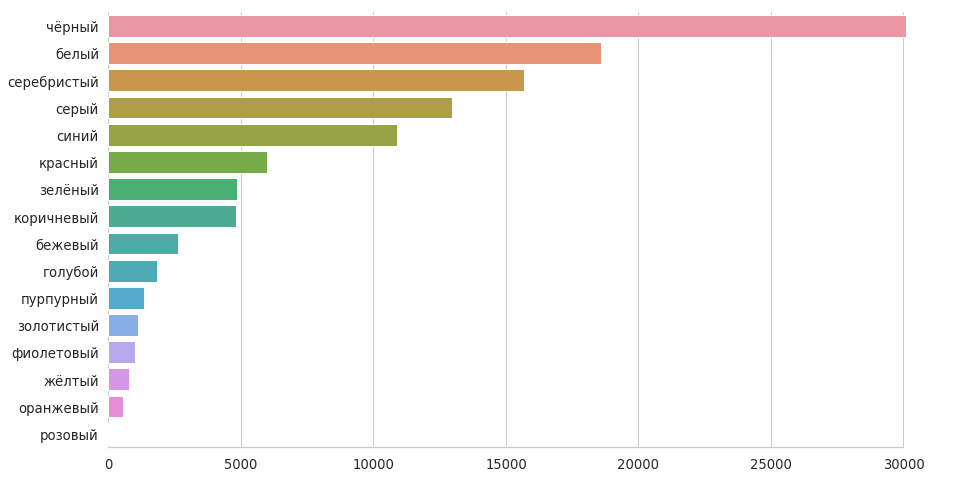

In [24]:
f, ax = plt.subplots(figsize=(15,8))
sns.countplot(y=df['color'], data=df, order=df['color'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

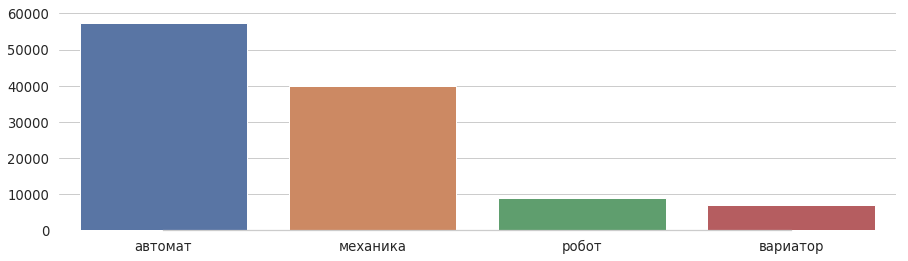

In [25]:
f, ax = plt.subplots(figsize=(15,4))
sns.countplot(x='transmission', data=df, order=df['transmission'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

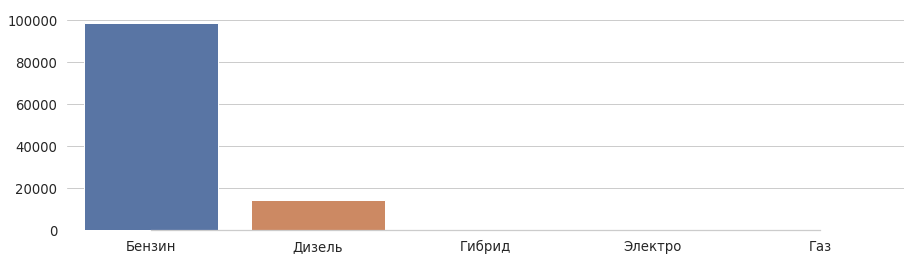

In [26]:
f, ax = plt.subplots(figsize=(15,4))
sns.countplot(x='gas', data=df, order=df['gas'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

### Статистическая оценка по категориям

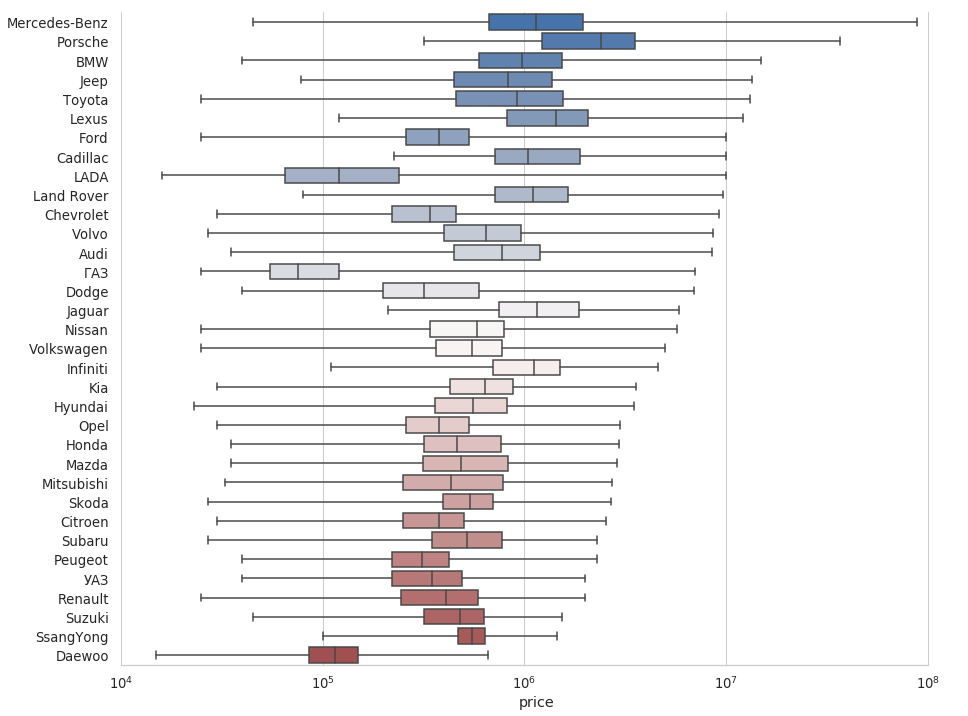

In [27]:
f, ax = plt.subplots(figsize=(15, 12))
ax.set_xscale("log")
sns.boxplot(x="price", y="manufacturer", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

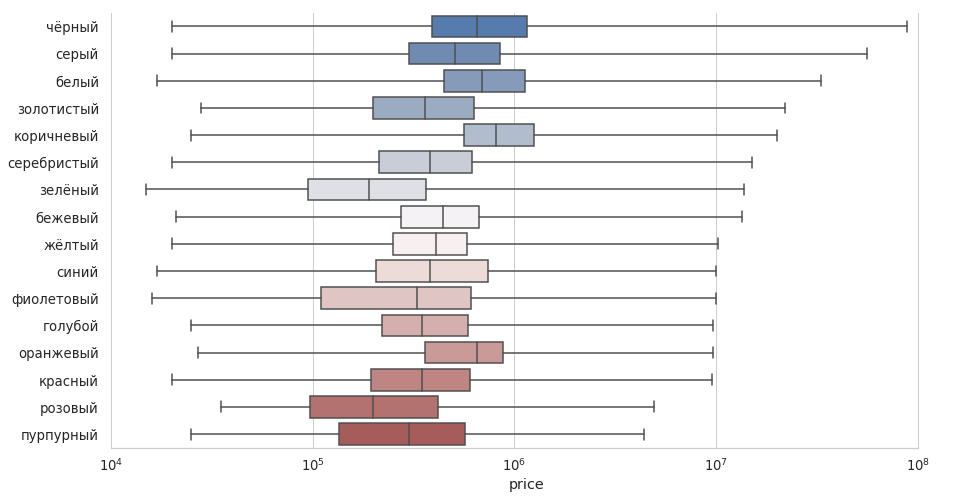

In [28]:
f, ax = plt.subplots(figsize=(15, 8))
ax.set_xscale("log")
sns.boxplot(x="price", y="color", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

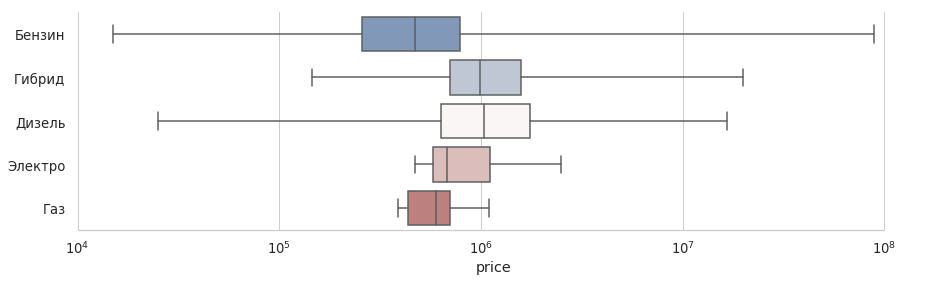

In [29]:
f, ax = plt.subplots(figsize=(15, 4))
ax.set_xscale("log")
sns.boxplot(x="price", y="gas", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

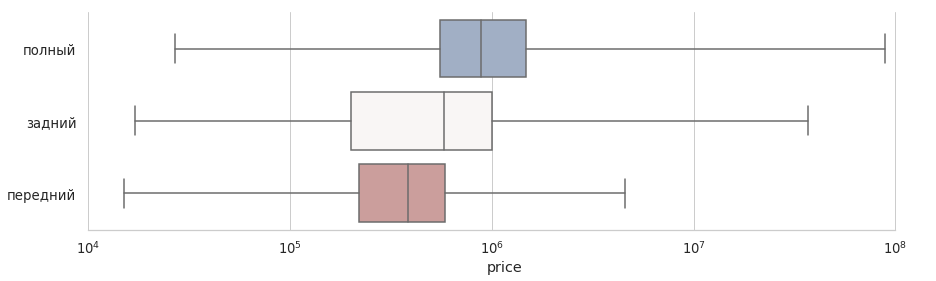

In [30]:
f, ax = plt.subplots(figsize=(15, 4))
ax.set_xscale("log")
sns.boxplot(x="price", y="drive", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

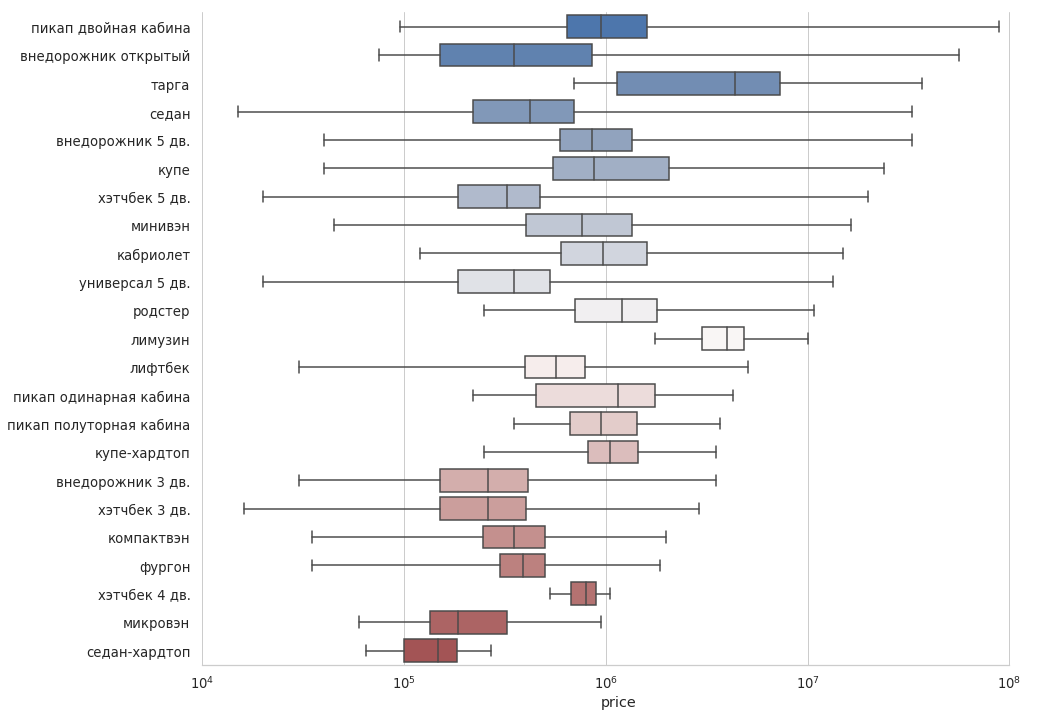

In [31]:
f, ax = plt.subplots(figsize=(15, 12))
ax.set_xscale("log")
sns.boxplot(x="price", y="body", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

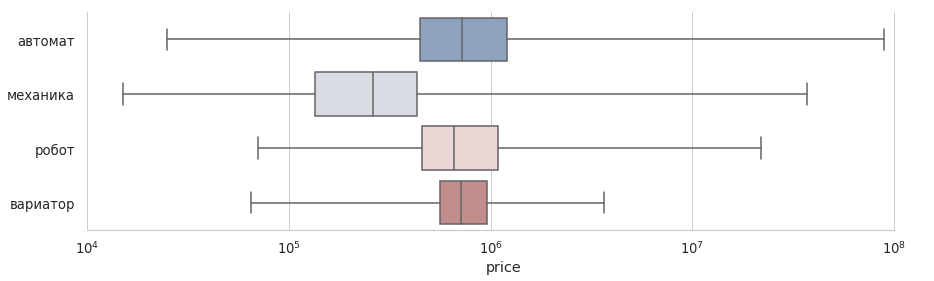

In [32]:
f, ax = plt.subplots(figsize=(15, 4))
ax.set_xscale("log")
sns.boxplot(x="price", y="transmission", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

### Попарные корреляции и распределения признаков

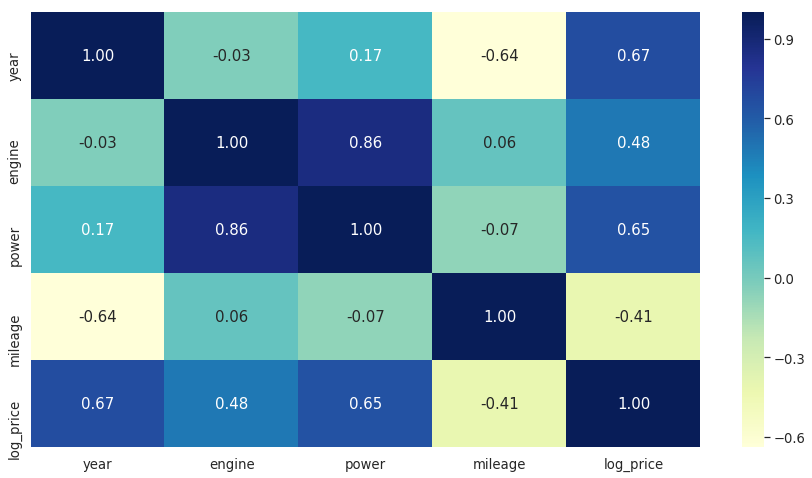

In [47]:
plt.figure(figsize=(15, 8))
df['log_price'] = df['price'].apply(lambda x: np.log(x))
corr_matrix=df[['year', 'engine', 'power', 'mileage', 'log_price']].corr()
sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True, cmap="YlGnBu", annot_kws={"size":15});

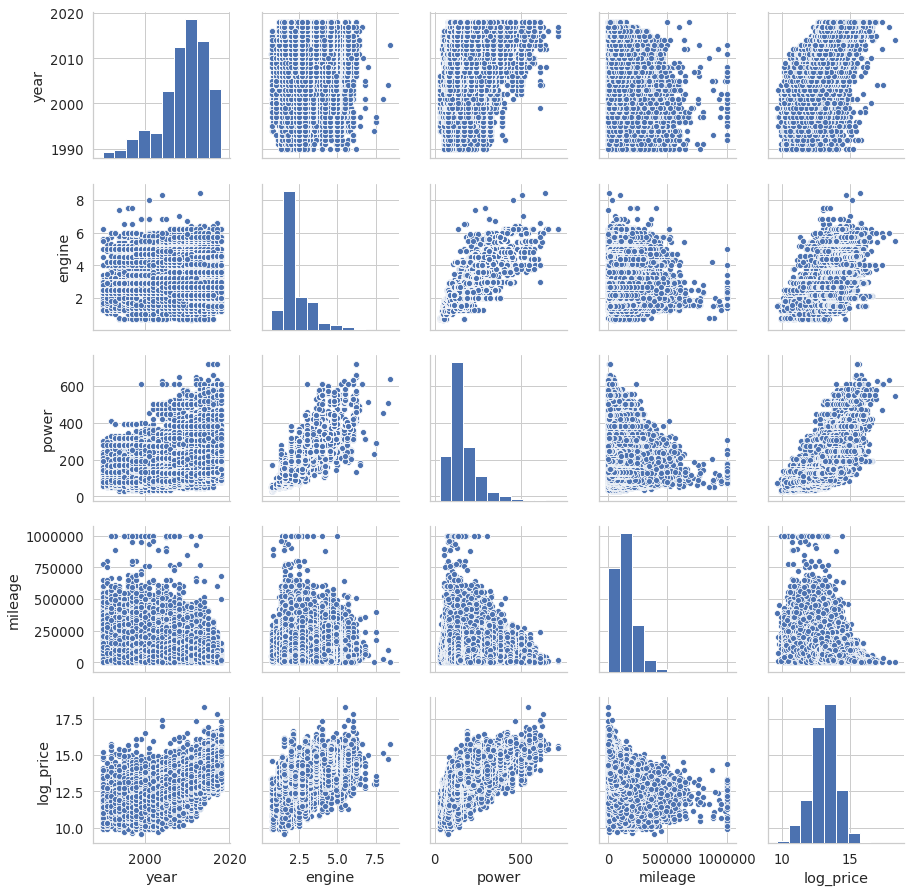

In [48]:
sns.pairplot(df[['year', 'engine', 'power', 'mileage', 'log_price']]);

Посмотрим на некоторые графики поближе

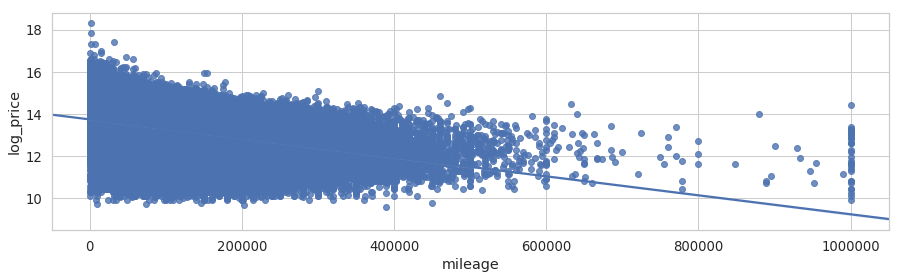

In [49]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='mileage', y='log_price', data=df, ax=ax);

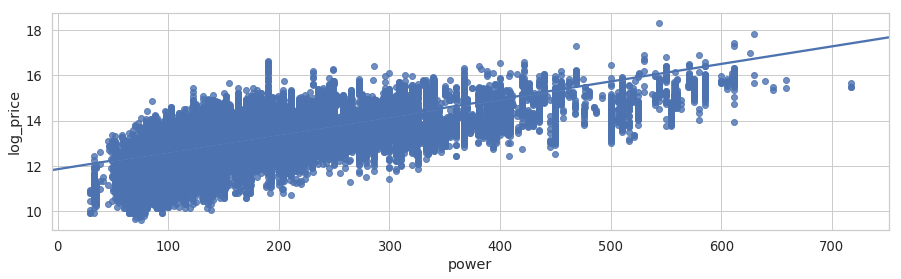

In [50]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='power', y='log_price', data=df, ax=ax);

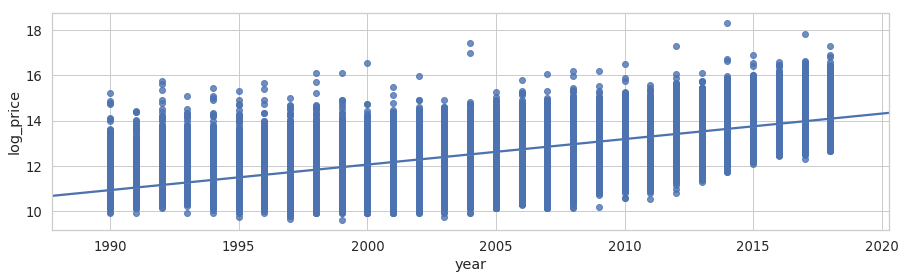

In [51]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='year', y='log_price', data=df, ax=ax);

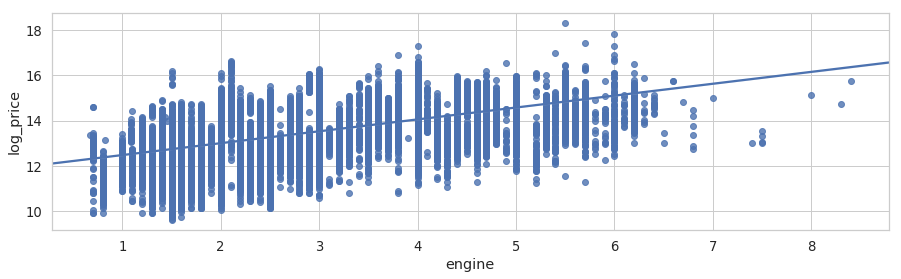

In [52]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='engine', y='log_price', data=df, ax=ax);

## Закономерности, особенности данных

### Распределения

* Распределение целевого признака визуально близко к логнормальному
* В распределении объявлений по году выпуска автомобиля явно наблюдается спад продаж новых автомобилей в 2009-2011 годах, вероятно, связанный с мировым финансовым кризисом
* Самые распространенные производители автомобилей: 
 - Lada 
 - Volkswagen
 - Mercedes-Benz 
 - BMW
 - Kia
* Самые распространенные формы кузова автомобилей: 
 - Седан 
 - Внедорожник 
 - Хэтчбек
* Самые распространенные цвета кузова автомобилей:
 - Черный
 - Белый
 - Серебристый
 - Серый 
 - Синий

### Категориальные признаки
 
* Наиболее дорогие автомобили были произведены маркой Mercedes-Benz, однако, если брать медианные показатели, то самый дорогой бренд Porsche
* Медианные данные премиальных брендов расположены довольно близко, исключение составляют Lexus и Porsche
* Наиболее дорогие автомобили, исходя из цвета кузова - черного цвета. Довольно неожиданно, что по медиане наиболее дорогой цвет - коричневый.
* Наиболее дорогие автомобили по типу двигателя, если брать медиану - дизельные, вероятно из-за того, что бюджетные модели редко бывают дизельными.
* Полный привод существенно повышает стоимость автомобиля на вторичном рынке. Задний привод так же повышает стоимость автомобиля.
* По форме кузова самыми дорогими автомобилями являются редкие варианты:
 - Тарга
 - Лимузин
 - Родстер
 - Кабриолет
 - Пикап
* Автомобили с механикой очевидно дешевле автомобилей с автоматом, роботом и вариатором

### Корреляции

* Цена уменьшается с увеличение пробега
* Цена растет с увеличением объема двигателя
* Цена на более старые автомобили - ниже
* Цена на более мощные автомобили - выше

## Выбор метрики

Выберем $R^2$ метрику, так как она наиболее наглядно показывает качество модели. Так же будем смотреть на RMSE, это поможет оценить насколько модель применима на практике.
## $$ R^2(y,\hat{y})
= 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y})^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2} 
= 1 - \frac{MSE(model)}{MSE(baseline)}$$
## $$ RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y})^2} = \sqrt{MSE} $$



## Выбор модели